# Split into training/test, find correlated features on train, use in model

Correlation stats can be found on all subject, but want to test performance of model based on correlation<br>
Train: 700<br>
Test: 130<br>
Bootstrap: x20<br>
Models: LR, MLP, LatSim<br>

Already have model predictions for Linear/Logistic Regression (all subs)
Need to redo predictions (all subs) with MLP, LatSim (next notebook)

Finally, need to do greedy (in two notebooks)

In [1]:
# Using newly preprocessed subjects

import pickle

metadictname = '/home/anton/Documents/Tulane/Research/PNC_Good/PNC_agesexwrat.pkl'
alltsname = '/home/anton/Documents/Tulane/Research/PNC_Good/PNC_PowerTS_float2.pkl'

with open(metadictname, 'rb') as f:
    metadict = pickle.load(f)

with open(alltsname, 'rb') as f:
    allts = pickle.load(f)
    
print(list(metadict.keys()))
print(list(allts.keys()))
print('Complete')

['age', 'sex', 'wrat', 'missingage', 'missingsex', 'missingwrat', 'failedqc']
['emoid', 'nback', 'rest']
Complete


In [2]:
'''
Get subjects that have all tasks and paras specified
Functions for creating independent and response variables
'''

import numpy as np

def get_subs(allts, metadict, tasks, paras):
    # Get subs for all paras
    for i,para in enumerate(paras):
        tmpset = set([int(sub[4:]) for sub in allts[para].keys()])
        if i == 0:
            paraset = tmpset
        else:
            paraset = paraset.intersection(tmpset)
    # Get subs for all tasks
    for i,task in enumerate(tasks):
        tmpset = set([sub for sub in metadict[task].keys()])
        if i == 0:
            taskset = tmpset
        else:
            taskset = paraset.intersection(tmpset)
    # Remove QC failures
    allsubs = taskset.intersection(paraset)
    for badsub in metadict['failedqc']:
        try:
            allsubs.remove(int(badsub[4:]))
        except:
            pass
    return list(allsubs)

def get_X(allts, paras, subs):
    X = []
    for para in paras:
        pX = [allts[para][f'sub-{sub}'] for sub in subs]
        pX = np.stack(pX)
        X.append(pX)
    return X

def get_y(metadict, tasks, subs):
    y = []
    for task in tasks:
        if task == 'age' or task == 'wrat':
            var = [metadict[task][sub] for sub in subs]
            var = np.array(var)
            y.append(var)
        if task == 'sex':
            maleness = [metadict[task][sub] == 'M' for sub in subs]
            maleness = np.array(maleness)
            sex = np.stack([maleness, 1-maleness], axis=1)
            y.append(sex)
    return y

subs = get_subs(allts, metadict, ['wrat'], ['rest', 'nback', 'emoid'])
print(len(subs))

X = get_X(allts, ['rest', 'nback', 'emoid'], subs)
print(X[0].shape)

830
(830, 264, 124)


In [4]:
# TS to condensed FC

from scipy import signal

def butter_bandpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = [cutoff[0] / nyq, cutoff[1] / nyq]
    b, a = signal.butter(order, normal_cutoff, btype='band', analog=False)
    return b, a

def butter_bandpass_filter(data, cutoff, fs, order=5):
    b, a = butter_bandpass(cutoff, fs, order=order)
    y = signal.filtfilt(b, a, data)
    return y

tr = 3

def filter_design_ts(X):
    Xs = []
    for i in range(X.shape[0]):
        nX = butter_bandpass_filter(X[i], [0.01, 0.15], 1/tr)
        Xs.append(nX)
    return np.stack(Xs)

def ts_to_flat_fc(X):
    p = np.corrcoef(X)
    a,b = np.triu_indices(p[0].shape[0], 1)
    p = p[a,b]
    return p

p = [np.stack([ts_to_flat_fc(ts) for ts in filter_design_ts(Xp)]) for Xp in X]
# Xfiltnorm = [tsmod/np.linalg.norm(tsmod, axis=(-1), keepdims=True) for tsmod in ts]
print(p[0].shape)

(830, 34716)


In [313]:
# Split into train and test

import torch
import torch.nn as nn
import torch.nn.functional as F

task = 'age'
para = 'emoid'
para_idx = 2
ntrain = 700

idcs = np.random.permutation(p[para_idx].shape[0])
x = p[para_idx]
x = x[idcs]
xtr = x[:ntrain]
xt = x[ntrain:]

mux = np.mean(xtr, axis=0, keepdims=True)
sigx = np.std(xtr, axis=0, keepdims=True)
xtr = xtr - mux
xt = xt - mux

y = get_y(metadict, [task], subs)[0]
y = y[idcs]
ytr = y[:ntrain]
yt = y[ntrain:]

mu = np.mean(ytr)
ytr = ytr - mu
yt = yt - mu

print([z.shape for z in [xtr, xt, ytr, yt]])

[(700, 34716), (130, 34716), (700,), (130,)]


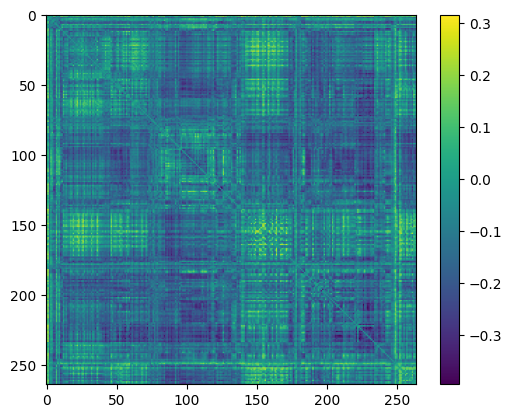

In [314]:
# Get correlation for train and top 30 features
# Visualize to check 

import matplotlib.pyplot as plt

def get_rho(x, y):
    xy = np.einsum('nd,n->d',x,y)
    xx = np.einsum('nd,nd->d',x,x)
    yy = np.einsum('n,n->',y,y)
    return xy/(xx*yy)**0.5

def vec2mat(v):
    a,b = np.triu_indices(264,1)
    mat = np.zeros((264,264))
    mat[a,b] = v
    mat = mat+mat.T
    return mat

rho = get_rho(xtr, ytr)
plt.imshow(vec2mat(rho))
plt.colorbar()
plt.show()

In [315]:
# Linear regression

idcs = np.argsort(np.abs(rho))
top_idcs = idcs[:]

xxtr = torch.from_numpy(xtr[:ntrain]).float().cuda()
xxt = torch.from_numpy(xt[:ntrain]).float().cuda()

yytr = torch.from_numpy(ytr[:ntrain]).float().cuda()
yyt = torch.from_numpy(yt[:ntrain]).float().cuda()

w,_,_,_ = torch.linalg.lstsq(xxtr, yytr)

yhat = xxt@w

mse = nn.MSELoss()
rmse = mse(yhat, yyt)**0.5
print(rmse)

tensor(23.8399, device='cuda:0')


In [311]:
# MLP 

class MLP(nn.Module):
    def __init__(self, d):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(d,40).float().cuda()
        self.fc2 = nn.Linear(40,1).float().cuda()
        
    def l1(self):
        return torch.mean(torch.abs(self.fc1.weight))
        
    def forward(self, x):
        x = F.relu(self.fc1(x))
        return self.fc2(x).squeeze()
    
nepochs = 1000
pperiod = 200

mlp = MLP(xxtr.shape[1])

# Optimizers
optim = torch.optim.Adam(mlp.parameters(), lr=1e-3, weight_decay=0)
sched = torch.optim.lr_scheduler.ReduceLROnPlateau(optim, patience=20, factor=0.75, eps=1e-7)

for epoch in range(nepochs):
    optim.zero_grad()
    yhat = mlp(xxtr)
    prloss = mse(yhat, yytr)
    l1loss = mlp.l1()
    totloss = prloss+0*l1loss
    totloss.backward()
    optim.step()
    if prloss < 121:
        break
    sched.step(totloss)
    if epoch % pperiod == 0 or epoch == nepochs-1:
        print(f'{epoch} recon: {[float(ls)**0.5 for ls in [prloss, l1loss]]} '
             f'lr: {sched._last_lr}')
        
print('Complete')

yhat = mlp(xxt)
rmse = mse(yhat, yyt)**0.5
print(rmse)

0 recon: [15.8213546145967, 0.05182431779617502] lr: [0.001]
Complete
tensor(14.8552, device='cuda:0', grad_fn=<PowBackward0>)


In [312]:
# LatSim

class LatSim(nn.Module):
    def __init__(self, d, ld=2):
        super(LatSim, self).__init__()
        self.A = nn.Parameter((torch.randn(d,ld)/(d**0.5)).float().cuda())
        
    def E(self, xtr, xt=None):
        AT = (xtr@self.A).T
        if xt is not None:
            A = xt@self.A
        else:
            A = AT.T
        E = A@AT
        return F.softmax(E,dim=1)
    
    def l1(self):
        return torch.mean(torch.abs(self.A))
        
    def forward(self, xtr, xt, ytr):
        E = self.E(xtr, xt)
        return E@ytr

sim = LatSim(xxtr.shape[1], ld=2)

nepochs = 300
pperiod = 200

# Optimizers
optim = torch.optim.Adam(sim.parameters(), lr=1e-4, weight_decay=0)
sched = torch.optim.lr_scheduler.ReduceLROnPlateau(optim, patience=20, factor=0.75, eps=1e-7)

for epoch in range(nepochs):
    optim.zero_grad()
    yhat = sim(xxtr, xxtr, yytr)
    loss = mse(yhat, yytr)
    l1 = sim.l1()
    totloss = loss+0*l1
    totloss.backward()
    optim.step()
    if loss < 121:
        break
    sched.step(loss)
    if epoch % pperiod == 0 or epoch == nepochs-1:
        print(f'{epoch} recon: {[float(ls)**0.5 for ls in [loss]]} lr: {sched._last_lr}')
        
print('Complete')

yhat = sim(xxtr, xxt, yytr)
rmse = mse(yhat, yyt)**0.5
print(rmse)

0 recon: [15.821015609375694] lr: [0.0001]
Complete
tensor(14.0196, device='cuda:0', grad_fn=<PowBackward0>)
